In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gurobipy as gp
from gurobipy import GRB
import pickle
import logging
import folium

Extract all the Point of Interests that are within the Woodlands area.

In [34]:
# Load the CSV file
poi_data = pd.read_csv("data/CombinedPOI.csv")

# Define a function to check if a point is within the Woodlands area
def is_within_woodlands(row):
    woodlands_longitude_range = (103.751, 103.803)  # Longitude range for Woodlands
    woodlands_latitude_range = (1.416, 1.466)       # Latitude range for Woodlands
    
    return (woodlands_longitude_range[0] <= row["longitude"] <= woodlands_longitude_range[1]) and \
           (woodlands_latitude_range[0] <= row["latitude"] <= woodlands_latitude_range[1])

# Filter the POI data to extract the entries within the Woodlands area
woodlands_pois_df = poi_data[poi_data.apply(is_within_woodlands, axis=1)]

# Print the extracted POIs in the Woodlands area
print("POIs in the Woodlands area:")
print(woodlands_pois_df)

#woodlands_pois_df.to_csv("woodlands_pois.csv") 

POIs in the Woodlands area:
                         name  latitude   longitude           type
21             1 MARSILING DR  1.440671  103.775740   HDB Property
34      1 WOODLANDS IND PK E3  1.454813  103.800069   HDB Property
62            10 MARSILING DR  1.440806  103.777319   HDB Property
70         10 WOODLANDS AVE 8  1.454287  103.800262   HDB Property
122       101 WOODLANDS ST 13  1.435983  103.781933   HDB Property
...                       ...       ...         ...            ...
12963  Woodlands Civic Centre  1.435150  103.786816  Shopping Mall
12969          Marsiling Mall  1.433543  103.779882  Shopping Mall
12973             Vista Point  1.430801  103.794105  Shopping Mall
12975          Woodlands Mart  1.445648  103.798162  Shopping Mall
12976   Woodlands North Plaza  1.442753  103.790548  Shopping Mall

[800 rows x 4 columns]


Extract all the carparks that are within the Woodlands area

In [8]:
# Load the CSV file
cp_data = pd.read_csv("data/CombinedCarpark.csv")

# Filter the POI data to extract the entries within the Woodlands area
woodlands_cp_df = cp_data[cp_data.apply(is_within_woodlands, axis=1)]

# Print the extracted POIs in the Woodlands area
print("Carparks in the Woodlands area:")
print(woodlands_cp_df)

#woodlands_cp_df.to_csv("woodlands_cp.csv") 

Carparks in the Woodlands area:
                        name  latitude   longitude                   type
485                     PDW5  1.430768  103.794146            HDB Carpark
486                     PDW7  1.445462  103.798061            HDB Carpark
487                     PDW8  1.438136  103.795151            HDB Carpark
488                     PD8W  1.443116  103.791046            HDB Carpark
977                      WCC  1.434902  103.786614            HDB Carpark
...                      ...       ...         ...                    ...
1204  Woodlands Civic Centre  1.435150  103.786816  Shopping Mall Carpark
1210          Marsiling Mall  1.433543  103.779882  Shopping Mall Carpark
1214             Vista Point  1.430801  103.794105  Shopping Mall Carpark
1216          Woodlands Mart  1.445648  103.798162  Shopping Mall Carpark
1217   Woodlands North Plaza  1.442753  103.790548  Shopping Mall Carpark

[101 rows x 4 columns]


In [9]:
# Create a map centered at Woodlands, Singapore
woodlands_map = folium.Map(location=[1.436, 103.786], zoom_start=13)

# Add markers for all the carparks in the Woodlands area (blue markers)
for _, row in woodlands_cp_df.iterrows():
    folium.Marker([row["latitude"], row["longitude"]], popup=row["name"], icon=folium.Icon(color='blue')).add_to(woodlands_map)

# Add markers for all the POIs in the Woodlands area (green markers)
for _, row in woodlands_pois_df.iterrows():
    folium.Marker([row["latitude"], row["longitude"]], popup=row["name"], icon=folium.Icon(color='green')).add_to(woodlands_map)

# Display the map
woodlands_map


## Calculate Distance Matrix
**Prompt**

I have 2 prepared datasets.
1. Carparks, with name, latitude, longtitude and type - this has 1273 carparks
2. Points of interest, with name, latitude, longtitude and type - this has 13032 POIs

Construct a D_ij matrix using the haversine formula. To improve time and space complexity, I only want to store distances that are 1000 meters (1km) or less. Store the results in a pickle file.

In [32]:
from math import radians, sin, cos, sqrt, atan2
import pickle
import pandas as pd

def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = 6371 * c  # Radius of Earth in kilometers
    return distance * 1000  # Convert to meters

# woodlands_cp_df = pd.read_csv("woodlands_cp.csv")
# woodlands_pois_df = pd.read_csv("woodlands_pois.csv")

# Function to construct distance matrix and save it to a pickle file
def construct_distance_matrix(woodlands_cp_df, woodlands_pois_df, filename):
    D_ij = {}

    for cp_index, carpark in woodlands_cp_df.iterrows():
        D_ij[cp_index] = {}

        for poi_index, poi in woodlands_pois_df.iterrows():
            distance = haversine_distance(
                carpark["latitude"],
                carpark["longitude"],
                poi["latitude"],
                poi["longitude"],
            )
            if distance <= 1000:  # Store distances <= 1000 meters
                D_ij[cp_index][poi_index] = distance

    # Save the distance matrix to a pickle file
    with open(filename, "wb") as f:
        pickle.dump(D_ij, f)

    return D_ij



In [33]:
pkl_filename = "data/woodlands_dist_matrix.pkl"
D_ij = construct_distance_matrix(woodlands_cp_df, woodlands_pois_df, pkl_filename)

D_ij

{485: {5964: 978.7883200495825,
  5975: 901.4765150302713,
  5989: 824.5116741498897,
  6003: 821.4484510038027,
  6013: 903.1607363024871,
  6019: 858.8285178763554,
  6022: 804.1041079951868,
  6050: 776.7462541171119,
  6051: 813.3864319404427,
  6057: 843.0907207968821,
  6058: 889.9448379962588,
  8106: 337.7447236206731,
  8126: 374.83120280533143,
  8129: 422.71060512145726,
  8149: 325.37402121996945,
  8168: 421.96472199731613,
  8192: 368.33251529209167,
  8196: 320.49798665704367,
  8217: 409.5764296892279,
  8238: 373.87982421143823,
  8259: 424.42741544246434,
  8278: 599.8208902175783,
  8280: 608.2432019437053,
  8317: 665.8964639569191,
  8335: 679.5860169468567,
  8354: 702.870057767666,
  8373: 623.3555233679701,
  8392: 654.6906566404662,
  8406: 598.6103581678875,
  8408: 591.8302985060093,
  8421: 556.1099748432747,
  8422: 532.896201163146,
  8432: 437.11553021584757,
  8435: 476.9313950820225,
  8449: 486.3401723461146,
  8463: 489.2505332956389,
  8465: 468.8798

In [12]:
print("size of outer D_ij: ", len(D_ij))
D_ij

size of outer D_ij:  101


{485: {5964: 978.7883200495825,
  5975: 901.4765150302713,
  5989: 824.5116741498897,
  6003: 821.4484510038027,
  6013: 903.1607363024871,
  6019: 858.8285178763554,
  6022: 804.1041079951868,
  6050: 776.7462541171119,
  6051: 813.3864319404427,
  6057: 843.0907207968821,
  6058: 889.9448379962588,
  8106: 337.7447236206731,
  8126: 374.83120280533143,
  8129: 422.71060512145726,
  8149: 325.37402121996945,
  8168: 421.96472199731613,
  8192: 368.33251529209167,
  8196: 320.49798665704367,
  8217: 409.5764296892279,
  8238: 373.87982421143823,
  8259: 424.42741544246434,
  8278: 599.8208902175783,
  8280: 608.2432019437053,
  8317: 665.8964639569191,
  8335: 679.5860169468567,
  8354: 702.870057767666,
  8373: 623.3555233679701,
  8392: 654.6906566404662,
  8406: 598.6103581678875,
  8408: 591.8302985060093,
  8421: 556.1099748432747,
  8422: 532.896201163146,
  8432: 437.11553021584757,
  8435: 476.9313950820225,
  8449: 486.3401723461146,
  8463: 489.2505332956389,
  8465: 468.8798

# EV Optimal Placement Optimisation
**Prompt**

Below is the problem formulation for the EV optimal placement optimisation problem.

Objective:

$$\text{Max} \sum_{i \in B} Y_{ij} \quad \forall j \in D$$

Decision Variables:
1. **Number of Chargers (Ni)**:
$$N_i \geq P, \forall i \in B$$

2. **Coverage Radius (Ri)**:
$$R_i = k \times N_i, \forall i \in B$$

3. **Distance Constraint**:
$$R_i \leq R_{\text{max}}$$

4. **Coverage Constraints (Yij)**:
$$D_{ij} \leq R_i + 99999 \times (1 - Y_{ij}), \forall i \in B, j \in D$$
$$D_{ij} \geq R_i - 99999 \times Y_{ij}, \forall i \in B, j \in D$$
$$\sum_{i \in B} Y_{ij} \geq 1, \forall j \in D$$

5. **Budget Constraint**:
$$\sum_{i \in B} C \times N_i \leq W$$

Assume the role of a data engineer specialized in data and prescriptive analytics. You are proficient in constructing mathematical models and adept at programming and solving these models using the Gurobi library. In our subsequent interactions, you will be tasked with coding various optimization models utilizing the Gurobi library. Your objectives are to ensure accurate results and adhere to the following guidelines:
1. Generate random parameters when specific parameters are not provided.
2. After solving each optimization problem, verify the problem status. If the status is "OPTIMAL", include code snippets to retrieve and display the optimal solutions and the objective value.
3. Disable output logging by setting the "OutputFlag" to 0.
4. Present the results in a concise and clear format, utilizing tables or graphical representations when beneficial.
5. Strive for code efficiency, utilizing the minimal amount of code necessary for model programming.
6. If possible, use “addVars” for non-scalar decision variables and use “addConstrs” for a batch of constraints. Also, please use “quicksum” instead of “sum”.
7. Be careful of the indices given that Python starts from 0 but most of the models start from 1. 
8. Make sure the code you provided fulfills all the requirements, i.e., a complete code should be provided. 

Please define the EV Charger Placement Optimisation problem as a function with detailed comments in the code, solve the problem and retrieve the optimal solutions and objective value, and return the solution.

(Note: Of course, the GAI generated code was modified quite significantly to meet all of above's complex requirements.)

In [69]:
def solve_ev_optimal_placement(B, D, P, k, R_max, C, W, D_ij, print_results=True):
    """
    Solve the EV Optimal Placement Optimization problem.

    Parameters:
    - B (int): Number of car parks.
    - D (int): Number of points of interest.
    - P (int): Minimum number of chargers required at each car park.
    - k (float): Constant for coverage radius calculation.
    - R_max (float): Maximum coverage radius.
    - C (float): Variable cost of installing one charging station.
    - W (float): Total budget.
    - D_ij (dict): Dictionary containing distances between car parks and points of interest.

    Returns:
    - model: Gurobi model object.
    """
    # Create a new Gurobi model
    model = gp.Model("EV_Optimal_Placement")

    # Disable output logging
    model.Params.OutputFlag = 0

    # Decision variables
    Ni = model.addVars(B, lb=P, vtype=GRB.INTEGER, name="Ni")  # Number of chargers
    Ri = model.addVars(B, name="Ri")  # Coverage radius
    Y = model.addVars(B, D, vtype=GRB.BINARY, name="Y")  # Coverage indicator

    # Objective function
    obj = gp.quicksum(Y[i, j] for i in range(B) for j in range(D))
    model.setObjective(obj, sense=GRB.MAXIMIZE)

    # Constraints
    # Number of chargers constraint
    model.addConstrs(
        (Ni[i] >= P for i in range(B)), name="charger_num_constr"
    )

    # Coverage radius constraint
    model.addConstrs(
        (Ri[i] == k * Ni[i] for i in range(B)), name="radius_constr"
    )

    # Distance constraint
    model.addConstrs(
        (Ri[i] <= R_max for i in range(B)), name="distance_constrs"
    )

    # Coverage constraints

    # print("Coverage constraints:")
    for i in range(B):
        for j in range(D):
            # D_ij.get(i, {}) returns an empty dictionary if i is not in D_ij
            # .get(j, None) returns None if j is not found in the dictionary returned by D_ij.get(i, {})
            distance = D_ij.get(i, {}).get(j, None)
            # print(f"Distance between car park {i} and point of interest {j}: {distance}")
            if distance is not None:
                model.addConstr(Y[i, j] * (Ri[i] + 99999 * (1 - Y[i, j])) >= distance, name=f"coverage_constrs_1_{i}_{j}")
                model.addConstr(Y[i, j] * (Ri[i] - 99999 * Y[i, j]) <= distance, name=f"coverage_constrs_2_{i}_{j}")
            # else:
            #     model.addConstr(Y[i, j] == 0, name=f"coverage_constrs_3_{i}_{j}")

    for j in range(D):
        model.addConstr(gp.quicksum(Y[i, j] for i in range(B)) >= 1, name=f"coverage_constrs_4_{j}")

    # Budget constraint
    model.addConstr(
        (gp.quicksum(C * Ni[i] for i in range(B)) <= W), name="budget_constr"
    )

    # Optimize the model
    model.optimize()

    # Verify problem status
    if model.status == GRB.OPTIMAL:
        # Retrieve and display optimal solutions
        # Charger placement at each car park
        if print_results == True:
            print("Charger Placement Results:")
            for i in range(B):
                print(f"Carpark {i}: Number of chargers = {Ni[i].x:.0f}, Coverage radius = {Ri[i].x:.2f} m")

            # Points of interest coverage
            print("\nPoints of Interest Coverage:")
            for j in range(D):
                covered = any(Y[i, j].x for i in range(B))
                print(f"Point of interest {j}: {'Covered' if covered else 'Not Covered'}")

            # Display objective value
            print(f"Total coverage: {model.objVal:.2f}")
            print(f"Proportion of points of interest covered: {model.objVal / D:.2f}")

        # Retrieve and display optimal solutions
        obj_value = model.objVal
        return model, obj_value
    else:
        print(f"No optimal solution found for {B} car parks, {D} points of interest, {P} minimum chargers, {R_max} max radius, {C} cost, {W} budget")
        return None

In [91]:
# Load the woodlands distance matrix from the pickle file
with open("woodlands_dm.pkl", "rb") as wl:
    D_ij = pickle.load(wl)

D_ij

{0: {231: 978.7883200495827,
  232: 901.4765150302713,
  233: 824.5116741498897,
  234: 821.4484510038027,
  235: 903.1607363024871,
  236: 858.8285178763554,
  237: 804.1041079951868,
  239: 776.7462541171119,
  240: 813.3864319404427,
  241: 843.0907207968821,
  242: 889.9448379962588,
  278: 337.7447236206731,
  279: 374.83120280533143,
  280: 422.71060512145726,
  281: 325.37402121996945,
  282: 421.96472199731613,
  283: 368.33251529209167,
  284: 320.49798665704367,
  285: 409.5764296892279,
  286: 373.87982421143823,
  287: 424.42741544246434,
  288: 599.8208902175783,
  289: 608.2432019437053,
  290: 665.8964639569191,
  291: 679.5860169468567,
  292: 702.870057767666,
  293: 623.3555233679701,
  294: 654.6906566404662,
  295: 598.6103581678875,
  296: 591.8302985060093,
  297: 556.1099748432747,
  298: 532.896201163146,
  299: 437.11553021584757,
  300: 476.9313950820225,
  301: 486.3401723461146,
  302: 489.2505332956389,
  303: 468.8798893632375,
  304: 425.70070574201765,
 

In [57]:
# ACTUAL

B = len(D_ij)  # Number of car parks
D = 800  # Number of points of interest
P = 3  # Minimum number of chargers required at each car park
k = 59.78  # Constant for coverage radius calculation (in meters)
R_max = 1100  # Maximum coverage radius (in meters)
C = 10500  # Variable cost of installing one charging station
W = 49984289  # Total budget for woodlands = [(101/1273)*60000]*10500 = 49984289 rounded to nearest integer


# Solve the EV Optimal Placement Optimization problem
model, soln = solve_ev_optimal_placement(B, D, P, k, R_max, C, W, D_ij)
model

Charger Placement Results:
Carpark 0: Number of chargers = 3, Coverage radius = 179.34 m
Carpark 1: Number of chargers = 3, Coverage radius = 179.34 m
Carpark 2: Number of chargers = 3, Coverage radius = 179.34 m
Carpark 3: Number of chargers = 3, Coverage radius = 179.34 m
Carpark 4: Number of chargers = 3, Coverage radius = 179.34 m
Carpark 5: Number of chargers = 3, Coverage radius = 179.34 m
Carpark 6: Number of chargers = 3, Coverage radius = 179.34 m
Carpark 7: Number of chargers = 3, Coverage radius = 179.34 m
Carpark 8: Number of chargers = 3, Coverage radius = 179.34 m
Carpark 9: Number of chargers = 3, Coverage radius = 179.34 m
Carpark 10: Number of chargers = 3, Coverage radius = 179.34 m
Carpark 11: Number of chargers = 3, Coverage radius = 179.34 m
Carpark 12: Number of chargers = 3, Coverage radius = 179.34 m
Carpark 13: Number of chargers = 3, Coverage radius = 179.34 m
Carpark 14: Number of chargers = 3, Coverage radius = 179.34 m
Carpark 15: Number of chargers = 3, Co

<gurobi.Model MIP instance EV_Optimal_Placement: 1104 constrs, 81002 vars, Parameter changes: Username=(user-defined), OutputFlag=0>

In [46]:
# Plot optimal placement of chargers
def plot_optimal_charger_placement(model, woodlands_cp_df, woodlands_pois_df):
    # Create a map centered at Woodlands, Singapore
    woodlands_map = folium.Map(location=[1.436, 103.786], zoom_start=13)


    # Add markers for all the POIs in the Woodlands area 
    for _, row in woodlands_pois_df.iterrows():
        if row["type"] == "HDB Property":
            #green markers if HDB property
            folium.Marker([row["latitude"], row["longitude"]], popup=row["name"], icon=folium.Icon(color='green')).add_to(woodlands_map)
        elif row["type"] == "Shopping Mall":
            #dark green markers if Shopping Mall
            folium.Marker([row["latitude"]+0.0001, row["longitude"]-0.0001], popup=row["name"], icon=folium.Icon(color='darkgreen')).add_to(woodlands_map)

    # Add markers for the optimal charger placement at each car park (red markers), otherwise blue markers
    for i in range(B):
        # Get the car park name corresponding to the index i
        carpark = woodlands_cp_df.iloc[i]
        carpark_name = woodlands_cp_df.iloc[i]["name"]

        if model.getVarByName(f"Ni[{i}]").x > 0:
            num_charger = model.getVarByName(f"Ni[{i}]").x
            popup_html = f"<b>Car Park:</b> {carpark_name}<br><b>Chargers:</b> {num_charger:.0f}"
            folium.Marker([carpark["latitude"], carpark["longitude"]], popup=popup_html, icon=folium.Icon(color='red')).add_to(woodlands_map)

            # Show radius coverage of car park with chargers
            radius = model.getVarByName(f"Ri[{i}]").x
            folium.Circle(location=[carpark["latitude"], carpark["longitude"]], radius=radius, color='red', fill=True, fill_color='red', fill_opacity=0.2).add_to(woodlands_map)
        else:
            # plot purple if no charger
            num_charger = 0
            popup_html = (f"<b>Car Park:</b> {carpark_name}<br><b>Chargers:</b> {num_charger:.0f}")
            folium.Marker([carpark["latitude"], carpark["longitude"]], popup=popup_html, icon=folium.Icon(color='blue')).add_to(woodlands_map)

    return woodlands_map

plot_optimal_charger_placement(model, woodlands_cp_df, woodlands_pois_df)

## Sensitivity Analysis

In [67]:
def plot_coverage_vs_parameter(parameter_values, coverages, parameter_name):
    """
    Plot the relationship between coverage and a given parameter.

    Parameters:
    - parameter_values (list): List of parameter values.
    - coverages (list): List of corresponding coverages.
    - parameter_name (str): Name of the parameter.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(parameter_values, coverages, marker="o", color="b")
    plt.title(f"Coverage vs {parameter_name}")
    plt.xlabel(parameter_name)
    plt.ylabel("Coverage")
    plt.grid(True)
    plt.show()


def analyze_coverage_vs_parameter(B, D, P, k, R_max, C, W, D_ij, parameter_values, parameter_name):
    """
    Analyze the relationship between coverage and a given parameter.

    Parameters:
    - B (int): Number of car parks.
    - D (int): Number of points of interest.
    - P (int): Minimum number of chargers required at each car park.
    - k (float): Constant for coverage radius calculation.
    - R_max (float): Maximum coverage radius.
    - C (float): Variable cost of installing one charging station.
    - W (float): Total budget.
    - D_ij (dict): Dictionary containing distances between car parks and points of interest.
    - parameter_values (list): List of parameter values to analyze.
    - parameter_name (str): Name of the parameter.
    """
    coverages = []
    result = None
    for value in parameter_values:
        if parameter_name == 'P':
            result = solve_ev_optimal_placement(B, D, value, k, R_max, C, W, D_ij, False)
        elif parameter_name == 'R_max':
            result = solve_ev_optimal_placement(B, D, P, k, value, C, W, D_ij, False)
        elif parameter_name == 'C':
            result = solve_ev_optimal_placement(B, D, P, k, R_max, value, W, D_ij, False)
        elif parameter_name == 'k':
            result = solve_ev_optimal_placement(B, D, P, value, R_max, C, W, D_ij, False)
        elif parameter_name == 'W':
            result = solve_ev_optimal_placement(B, D, P, k, R_max, C, value, D_ij, False)
        else:
            raise ValueError("Invalid parameter name")
        
        if result is not None:
            model, _ = result
            total_coverage = sum(1 for j in range(D) if any(model.getVarByName(f"Y[{i},{j}]").x for i in range(B)))
            coverages.append(total_coverage)
        else:
            coverages.append(0)
    
    plot_coverage_vs_parameter(parameter_values, coverages, parameter_name)

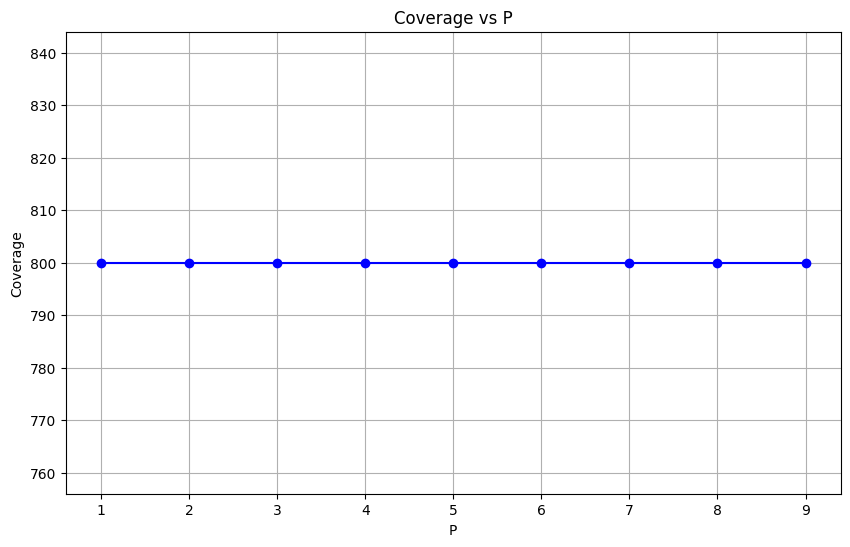

No optimal solution found for 101 car parks, 800 points of interest, 3 minimum chargers, 100 max radius, 10500 cost, 49984289 budget


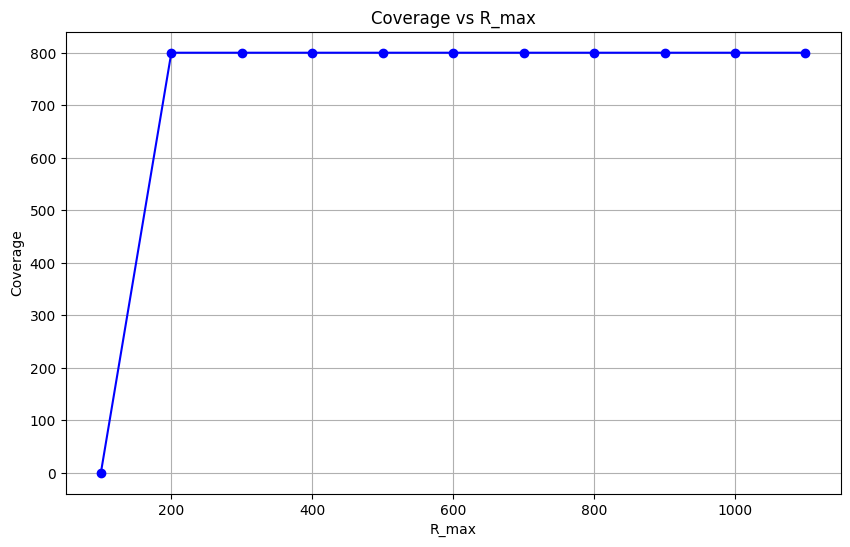

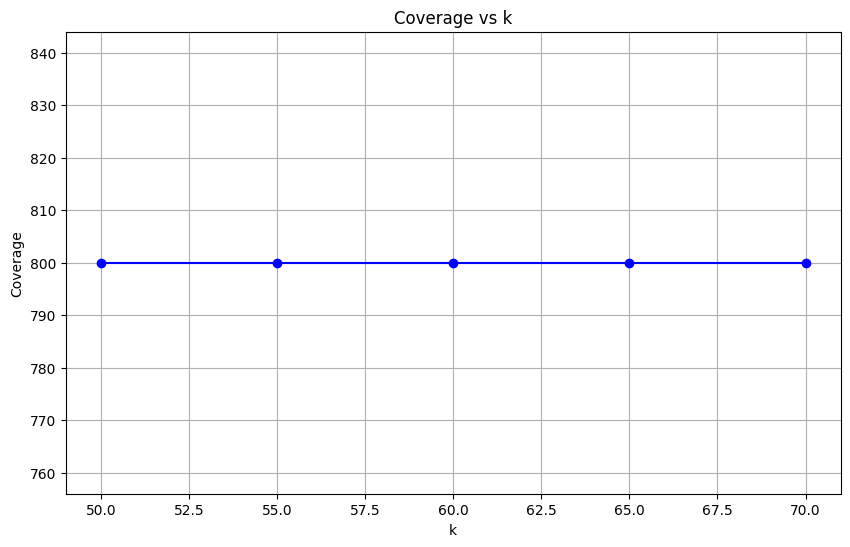

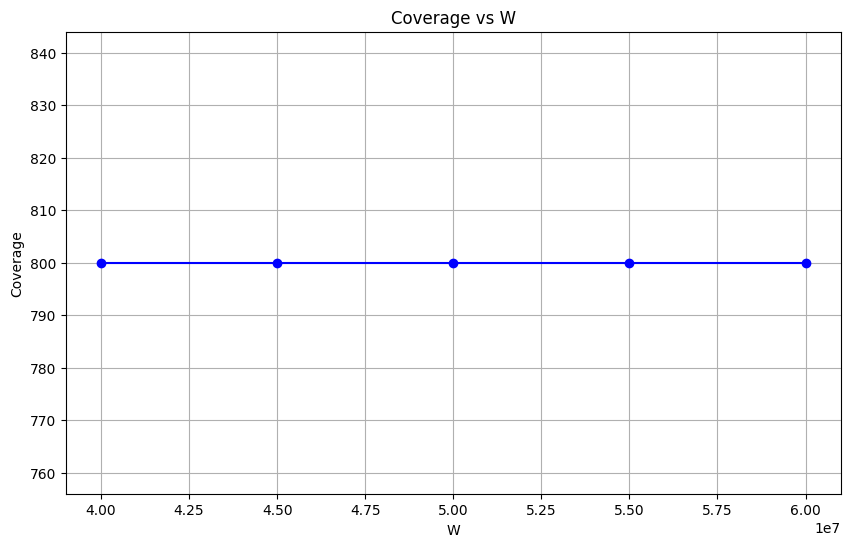

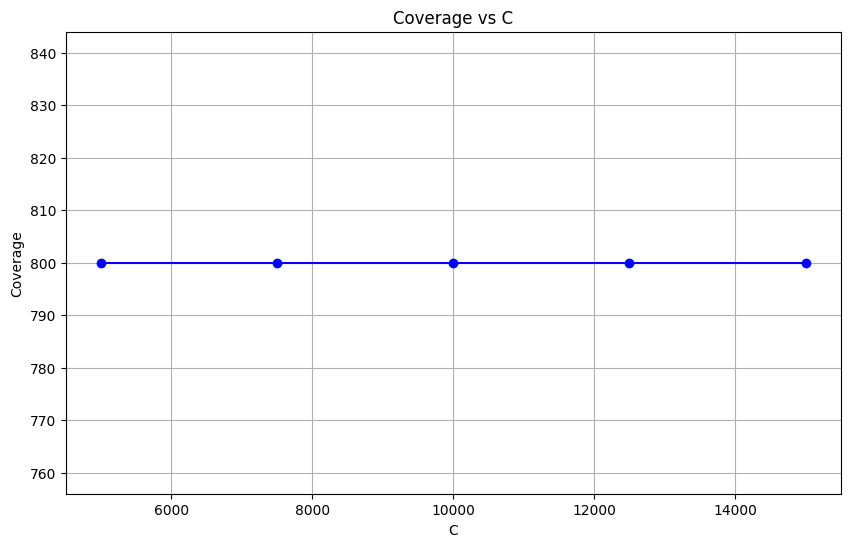

In [70]:
# Analyze coverage vs. minimum number of chargers (P)
min_chargers_values = range(1, 10)  # Minimum number of chargers
analyze_coverage_vs_parameter(B, D, P, k, R_max, C, W, D_ij, min_chargers_values, 'P')

# Analyze coverage vs. maximum coverage radius (R_max)
max_radius_values = range(100, 1101, 100)  #Maximum coverage radius
analyze_coverage_vs_parameter(B, D, P, k, R_max, C, W, D_ij, max_radius_values, 'R_max')

# Analyze coverage vs. constant for coverage radius calculation (k)
# middle value = 59.78
constant_values = [50, 55, 60, 65, 70]  # Constant values
analyze_coverage_vs_parameter(B, D, P, k, R_max, C, W, D_ij, constant_values, 'k')

#Analyze coverage vs budget (W)
# middle value = 49984289
budget_values = [40000000, 45000000, 50000000, 55000000, 60000000]  # Budget values
analyze_coverage_vs_parameter(B, D, P, k, R_max, C, W, D_ij, budget_values, 'W')

# Analyze coverage vs. variable cost of installing charging stations (C)
# middle value 10,500
cost_values = [5000, 7500, 10000, 12500, 15000]  # Example values for variable cost
analyze_coverage_vs_parameter(B, D, P, k, R_max, C, W, D_ij, cost_values, "C")